# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

Fuente: https://github.com/Yangyangii/GAN-Tutorial


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = '/content/drive/My Drive/CIA_marcos/deep_learning/clase_8/GANs'

Mounted at /content/drive


In [6]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# defino el tamaño del vector del ruido del cual deseo generar a imagen.
n_noise = 100

In [8]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=n_noise, num_classes=784): # input_size lo elijo yo,
                                                             # es el vector de números aleatorios del cual deseo partir.
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28) # la salida le doy formato de imagen de MNIST [batchx1x28x28]
        return y_

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1): # input_size, la imagen MNIST vectorizada, num_classes=1 (REAL or FAKE)
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y_ = x.view(x.size(0), -1) # vectorizo la imagen MNIST
        y_ = self.layer(y_)
        return y_

In [10]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) # genero un batch de 100 vectores randn
                                            # del tamaño definido en n_noise.
    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [31]:
# instancio los modelos
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)


In [32]:
# puedo cargar un modelo ya entrenado
D.load_state_dict(torch.load(data_dir + '/D_nnoise_100_e_100.pkl', map_location=DEVICE, weights_only=False))


<All keys matched successfully>

In [33]:
G.load_state_dict(torch.load(data_dir + '/G_nnoise_100_e_100.pkl', map_location=DEVICE, weights_only=False))

<All keys matched successfully>

In [12]:
# transformación para normalizar el dataset.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [13]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 354kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]


In [14]:
batch_size = 32 #32 original

In [15]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [16]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
max_epoch = 30 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [18]:
D_true = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [19]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [20]:
step = 0
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        # el discriminador debe ser entenado para poder reconocer imagenes
        # REAL vs FAKE

        # le paso imagenes de verdad y etiquetas de verdad.
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_true)

        # le paso imágenes falsas y etiquetas falsas.
        z = torch.randn(batch_size, n_noise).to(DEVICE) # vector randn
        fake_im = G(z) # genero con el generador
        z_outputs = D(fake_im) # las paso por el Discriminador
        D_z_loss = criterion(z_outputs, D_fakes) # comparo con etiquetas FAKE

        # perdida total discriminador
        D_loss = D_x_loss + D_z_loss # sumo ambas pérdidas

        # optimizo el Discriminador
        D.zero_grad()
        D_loss.backward()
        D_opt.step()


        if step % n_critic == 0:
            # Training Generator
            # el Generador, debe ser entrenado para engañar al Discriminador!
            # para esto, le paso imágenes falsas al Discriminador, CON ETIQUETAS REALES!
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_true)

            # optimizo SOLO el Generador
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # lineas plara sacar resultados parciales o imágenes parciales
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/30, Step: 0, D Loss: 1.3465476036071777, G Loss: 0.7139233350753784
Epoch: 0/30, Step: 500, D Loss: 1.4571350812911987, G Loss: 1.2779293060302734
Epoch: 0/30, Step: 1000, D Loss: 1.2108732461929321, G Loss: 1.060486078262329
Epoch: 0/30, Step: 1500, D Loss: 1.2064327001571655, G Loss: 1.0384058952331543
Epoch: 1/30, Step: 2000, D Loss: 1.1415296792984009, G Loss: 0.8293330669403076
Epoch: 1/30, Step: 2500, D Loss: 1.163831353187561, G Loss: 0.8569378852844238
Epoch: 1/30, Step: 3000, D Loss: 1.2948552370071411, G Loss: 1.4903032779693604
Epoch: 1/30, Step: 3500, D Loss: 1.1164937019348145, G Loss: 1.0111205577850342
Epoch: 2/30, Step: 4000, D Loss: 1.1950430870056152, G Loss: 0.9868015050888062
Epoch: 2/30, Step: 4500, D Loss: 1.1812117099761963, G Loss: 0.7558482885360718
Epoch: 2/30, Step: 5000, D Loss: 1.1574962139129639, G Loss: 0.9557858109474182
Epoch: 2/30, Step: 5500, D Loss: 1.3093879222869873, G Loss: 0.9783473610877991
Epoch: 3/30, Step: 6000, D Loss: 1.25744307041

## Visualize Sample

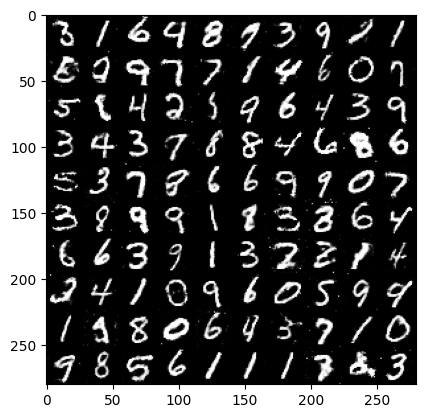

In [34]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

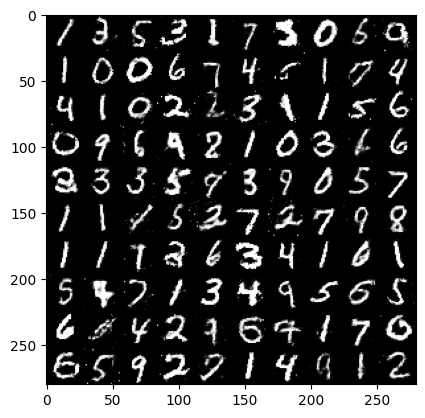

In [22]:
# generation to image (esto fue con 30 epochs)
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [ ]:
# Saving params.
#torch.save(D.state_dict(), data_dir + '/D_nnoise_100_e_100.pkl')
#torch.save(G.state_dict(), data_dir + '/G_nnoise_100_e_100.pkl')

In [23]:
def get_sample_image_col(G, n_noise, z):
    """
        save sample 100 images
    """

    # lo repito 100 veces para generas 100 imagenes
    z2 =  z.repeat(100, 1)

    # defino un spam de valores para reemplazar en una columna
    # recuerdo que mi generador es una randn (distribución normal con media=0 y varianza=1)
    # por lo que en -3 a +3 tendré el 99.9% de los valores que pude haber visto el G
    a = torch.linspace(-3,3,100)

    # elejir que columna deseo reemplazar
    # la cambio a azar
    n = np.random.randint(n_noise)
    print(f'Columna variada: {n}')
    #n = 92
    z2[:,n] = a

    # le paso ese batch al Generador y reordeno la salida que me da.
    y_hat = G(z2).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()

    # preparo array para guardar los 100 resultados del generador
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img


In [ ]:
n_noise

In [24]:
# genero un batch de 1 vector randn del tamaño definido en n_noise que voy a utilizar en lo que sigue
z = torch.randn(1, n_noise).to(DEVICE)

In [26]:
z

tensor([[ 0.3213,  0.5583, -0.4501,  1.3234, -1.9607, -0.5912,  1.5188, -1.1480,
         -0.8515, -1.0754,  0.6738,  0.4764,  0.3837,  0.0930,  0.9300,  0.7799,
          1.7717,  1.3506, -2.2030, -0.8313, -0.2610, -0.9149,  0.5077,  0.3656,
          0.5205,  0.0065, -0.7825,  0.2660, -0.6340,  0.5679,  1.0576, -0.0524,
          0.2038, -0.3383, -0.1334,  0.6248,  1.7020,  0.0203,  1.2379,  0.0439,
         -0.3410, -0.0308, -2.9898, -1.1543,  1.0845, -1.5875, -0.9244,  1.3831,
         -0.4062, -0.4694, -0.4402,  1.8300,  0.0953, -0.5988,  0.8223,  1.0529,
         -0.1576,  0.7032,  0.0828,  1.3544, -1.0582,  1.1493, -0.2448,  0.4957,
         -0.6440, -0.2179,  0.6772,  0.2279,  1.3214, -0.2674, -0.1373, -0.3564,
          2.3365, -1.0776,  0.7150,  0.0821,  1.1216,  0.2074, -1.2080, -2.1277,
         -0.0032,  0.0993,  1.6496, -0.3450,  0.3848,  1.1373, -0.7990,  1.2814,
          0.0560,  0.7977,  0.9571, -0.4047, -1.5736,  0.4821, -0.2924, -0.4204,
          1.4730,  0.1707,  

Columna variada: 47


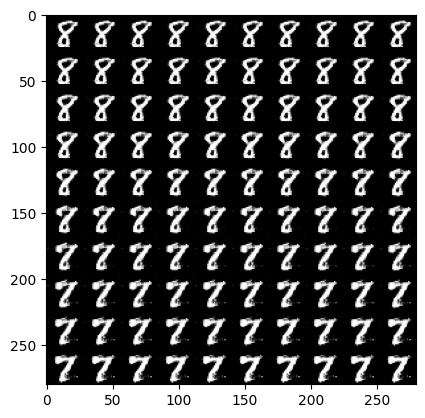

In [30]:
imshow(get_sample_image_col(G, n_noise, z), cmap='gray')

In [ ]:
z